In [1]:
import os
import glob
import time
import sys
import warnings
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
from tqdm import tqdm
from ultralytics import YOLO
import zarr
from scipy.spatial import cKDTree
from collections import defaultdict

In [2]:
model_path = '../input/model/best.pt'
model = YOLO(model_path)
runs_path = '../input/czii-cryo-et-object-identification/train/static/ExperimentRuns/*'
runs = sorted(glob.glob(runs_path))
runs = ['TS_5_4']
runs = [os.path.basename(run) for run in runs]
sp = len(runs)//2
runs1 = runs[:sp]
runs1[:5]

#add by @minfuka
runs2 = runs[sp:]
runs2[:5]

#add by @minfuka
assert torch.cuda.device_count() == 10

In [3]:
particle_names = [
    'apo-ferritin',
    'beta-amylase',
    'beta-galactosidase',
    'ribosome',
    'thyroglobulin',
    'virus-like-particle'
]

particle_to_index = {
    'apo-ferritin': 0,
    'beta-amylase': 1,
    'beta-galactosidase': 2,
    'ribosome': 3,
    'thyroglobulin': 4,
    'virus-like-particle': 5
}

index_to_particle = {index: name for name, index in particle_to_index.items()}

particle_radius = {
    'apo-ferritin': 60,
    'beta-amylase': 65,
    'beta-galactosidase': 90,
    'ribosome': 150,
    'thyroglobulin': 130,
    'virus-like-particle': 135,
}

In [39]:
# add by @sesasj
class UnionFind:
    def __init__(self, size):
        self.parent = np.arange(size)
        self.rank = np.zeros(size, dtype=int)

    def find(self, u):
        if self.parent[u] != u:
            self.parent[u] = self.find(self.parent[u])  
        return self.parent[u]

    def union(self, u, v):
        u_root = self.find(u)
        v_root = self.find(v)
        if u_root == v_root:
            return
            
        if self.rank[u_root] < self.rank[v_root]:
            self.parent[u_root] = v_root
        else:
            self.parent[v_root] = u_root
            if self.rank[u_root] == self.rank[v_root]:
                self.rank[u_root] += 1

class PredictionAggregator:
    def __init__(self, first_conf=0.2, conf_coef=0.75,particle_confs=None): 
        self.first_conf = first_conf
        self.conf_coef = conf_coef
        
        self.particle_confs = particle_confs
        
    def convert_to_8bit(self, volume):
        lower, upper = np.percentile(volume, (0.5, 99.5))
        clipped = np.clip(volume, lower, upper)
        scaled = ((clipped - lower) / (upper - lower + 1e-12) * 255).astype(np.uint8)
        return scaled

    def make_predictions(self, run_id, model, device_no):
        volume_path = f'../input/czii-cryo-et-object-identification/train/static/ExperimentRuns/{run_id}/VoxelSpacing10.000/denoised.zarr'
        #print(volume_path)
        volume = zarr.open(volume_path, mode='r')[0]
        volume_8bit = self.convert_to_8bit(volume)
        num_slices = volume_8bit.shape[2]

        detections = {
            'particle_type': [],
            'confidence': [],
            'x': [],
            'y': [],
            'z': []
        }

        for slice_idx in range(num_slices):
            
            img = volume_8bit[:,:,slice_idx]
            input_image = cv2.resize(np.stack([img]*3, axis=-1), (640, 192))

            results = model.predict(
                input_image,
                save=False,
                imgsz=(640, 640), 
                conf=self.first_conf,
                device=device_no,
                batch=1,
                verbose=False,
            )
            # デバッグ表示：slice_idx が 30 の場合、画像にバウンディングボックスとクラス情報を描画して表示
            if slice_idx == 10000:
                print(run_id)
                debug_img = input_image.copy()
                for result in results:
                    boxes = result.boxes
                    if boxes is None:
                        continue
                    # クラス（番号）、信頼度、バウンディングボックス座標を取得
                    cls_array = boxes.cls.cpu().numpy().astype(int)
                    conf_array = boxes.conf.cpu().numpy()
                    xyxy_array = boxes.xyxy.cpu().numpy().astype(int)
                    particle_types = [index_to_particle[c] for c in cls_array]
                    for box, cls_id, conf_val in zip(xyxy_array, cls_array, conf_array):
                        x1, y1, x2, y2 = box
                        # 緑色の矩形を描画
                        cv2.rectangle(debug_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                        # クラス番号のテキスト（番号だけ表示）
                        label = f"{particle_types}"
                        print(particle_types)
                        particle_types = [index_to_particle[c] for c in cls]
                        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                        cv2.rectangle(debug_img, (x1, y1 - h - 4), (x1 + w, y1), (0, 0, 0), -1)
                        cv2.putText(debug_img, label, (x1, y1 - 2),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
                # matplotlib で表示（BGR→RGB変換）
                debug_img_rgb = cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB)
                plt.figure(figsize=(8, 4))
                plt.imshow(debug_img_rgb)
                plt.title(f"Slice {slice_idx} with Detected Boxes (Class Numbers)")
                plt.axis('off')
                plt.show()

            for result in results:
                boxes = result.boxes
                if boxes is None:
                    continue
                cls = boxes.cls.cpu().numpy().astype(int)
                conf = boxes.conf.cpu().numpy()
                xyxy = boxes.xyxy.cpu().numpy()

                xc = ((xyxy[:, 0] + xyxy[:, 2]) / 2.0) * 10 * (630/640) # 63/64 because of the resize
                yc = ((xyxy[:, 1] + xyxy[:, 3]) / 2.0) * 10 * (184/192)
                zc = np.full(xc.shape, slice_idx * 10 + 5)

                particle_types = [index_to_particle[c] for c in cls]

                detections['particle_type'].extend(particle_types)
                detections['confidence'].extend(conf)
                detections['y'].extend(xc)
                detections['z'].extend(yc)
                detections['x'].extend(zc)

        if not detections['particle_type']:
            return pd.DataFrame()  

        particle_types = np.array(detections['particle_type'])
        confidences = np.array(detections['confidence'])
        xs = np.array(detections['x'])
        ys = np.array(detections['y'])
        zs = np.array(detections['z'])

        aggregated_data = []

        for idx, particle in enumerate(particle_names):
            if particle == 'beta-amylase':
                continue 

            mask = (particle_types == particle)
            if not np.any(mask):
                continue  
                
            particle_confidences = confidences[mask]
            particle_xs = xs[mask]
            particle_ys = ys[mask]
            particle_zs = zs[mask]
            # -------------modified by @sersasj ------------------------
            coords = np.vstack((particle_xs, particle_ys, particle_zs)).T

           
            z_distance = 30 # How many slices can you "jump" to aggregate predictions 10 = 1, 20 = 2...
            xy_distance = 20 # xy_tol_p2 in original code by ITK8191
            
            max_distance = math.sqrt(z_distance**2 + xy_distance**2)
            tree = cKDTree(coords)            
            pairs = tree.query_pairs(r=max_distance, p=2)

            
            uf = UnionFind(len(coords))
            
            coords_xy = coords[:, :2]
            coords_z = coords[:, 2]
            for u, v in pairs:
                z_diff = abs(coords_z[u] - coords_z[v])
                if z_diff > z_distance:
                    continue  

                xy_diff = np.linalg.norm(coords_xy[u] - coords_xy[v])
                if xy_diff > xy_distance:
                    continue  

                uf.union(u, v)

            roots = np.array([uf.find(i) for i in range(len(coords))])
            unique_roots, inverse_indices, counts = np.unique(roots, return_inverse=True, return_counts=True)
            conf_sums = np.bincount(inverse_indices, weights=particle_confidences)
            
            aggregated_confidences = conf_sums / (counts ** self.conf_coef)
            cluster_per_particle = [4,1,2,9,4,8] # Update
            valid_clusters = (counts >= cluster_per_particle[idx]) & (aggregated_confidences > self.particle_confs[idx])

            if not np.any(valid_clusters):
                continue  

            cluster_ids = unique_roots[valid_clusters]

            centers_x = np.bincount(inverse_indices, weights=particle_xs) / counts
            centers_y = np.bincount(inverse_indices, weights=particle_ys) / counts
            centers_z = np.bincount(inverse_indices, weights=particle_zs) / counts

            centers_x = centers_x[valid_clusters]
            centers_y = centers_y[valid_clusters]
            centers_z = centers_z[valid_clusters]

            aggregated_df = pd.DataFrame({
                'experiment': [run_id] * len(centers_x),
                'particle_type': [particle] * len(centers_x),
                'x': centers_x,
                'y': centers_y,
                'z': centers_z
            })

            aggregated_data.append(aggregated_df)

        if aggregated_data:
            return pd.concat(aggregated_data, axis=0)
        else:
            return pd.DataFrame()  

In [5]:
runs = ['TS_5_4']

In [7]:
# instance main class
aggregator = PredictionAggregator(first_conf=0.19,  conf_coef=0.34) #Update
aggregated_results = []


#add by @minfuka
from concurrent.futures import ProcessPoolExecutor #add by @minfuka

#add by @minfuka
def inference(runs, model, device_no):
    subs = []
    for r in tqdm(runs, total=len(runs)):
        df = aggregator.make_predictions(r, model, device_no)
        subs.append(df)
    
    return subs


start_time = time.time()

with ProcessPoolExecutor(max_workers=2) as executor:
    results = list(executor.map(inference, (runs1, runs2), (model, model), ("0", "1")))


end_time = time.time()

estimated_total_time = (end_time - start_time) / len(runs) * 500  
print(f'estimated total prediction time for 500 runs: {estimated_total_time:.4f} seconds')
submission = pd.concat(results[1])
submission.insert(0, 'id', range(len(submission)))
submission.to_csv("submission.csv", index=False)
submission.head()

0it [00:00, ?it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

../input/czii-cryo-et-object-identification/train/static/ExperimentRuns/TS_5_4/VoxelSpacing10.000/denoised.zarr


100%|██████████| 1/1 [00:15<00:00, 15.30s/it]


estimated total prediction time for 500 runs: 8226.0907 seconds


['TS_5_4']
 TS_5_4 virus-like-particle
         particle_type  P   T  hit  miss  fp  precision    recall   f-beta4  \
0         apo-ferritin  4  46    3    43   1   0.750000  0.065217  0.068919   
1         beta-amylase  0  10    0    10   0   0.000000  0.000000  0.000000   
2   beta-galactosidase  0  12    0    12   0   0.000000  0.000000  0.000000   
3             ribosome  9  31    9    22   0   1.000000  0.290323  0.302970   
4        thyroglobulin  5  30    2    28   3   0.400000  0.066667  0.070103   
5  virus-like-particle  7  11    6     5   1   0.857143  0.545455  0.557377   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score: 0.15278177867085146

TS_5_4 apo-ferritin
	 num truth   : 46
	 num predict : 4
	 num hit  : 4
	 num fp   : 0
	 num miss : 42
TS_5_4 beta-amylase
	 num truth   : 10
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 10
TS_5_4 beta-galactosidase
	 num truth   : 12
	 num predict : 0
	 num hit  : 0
	 num fp

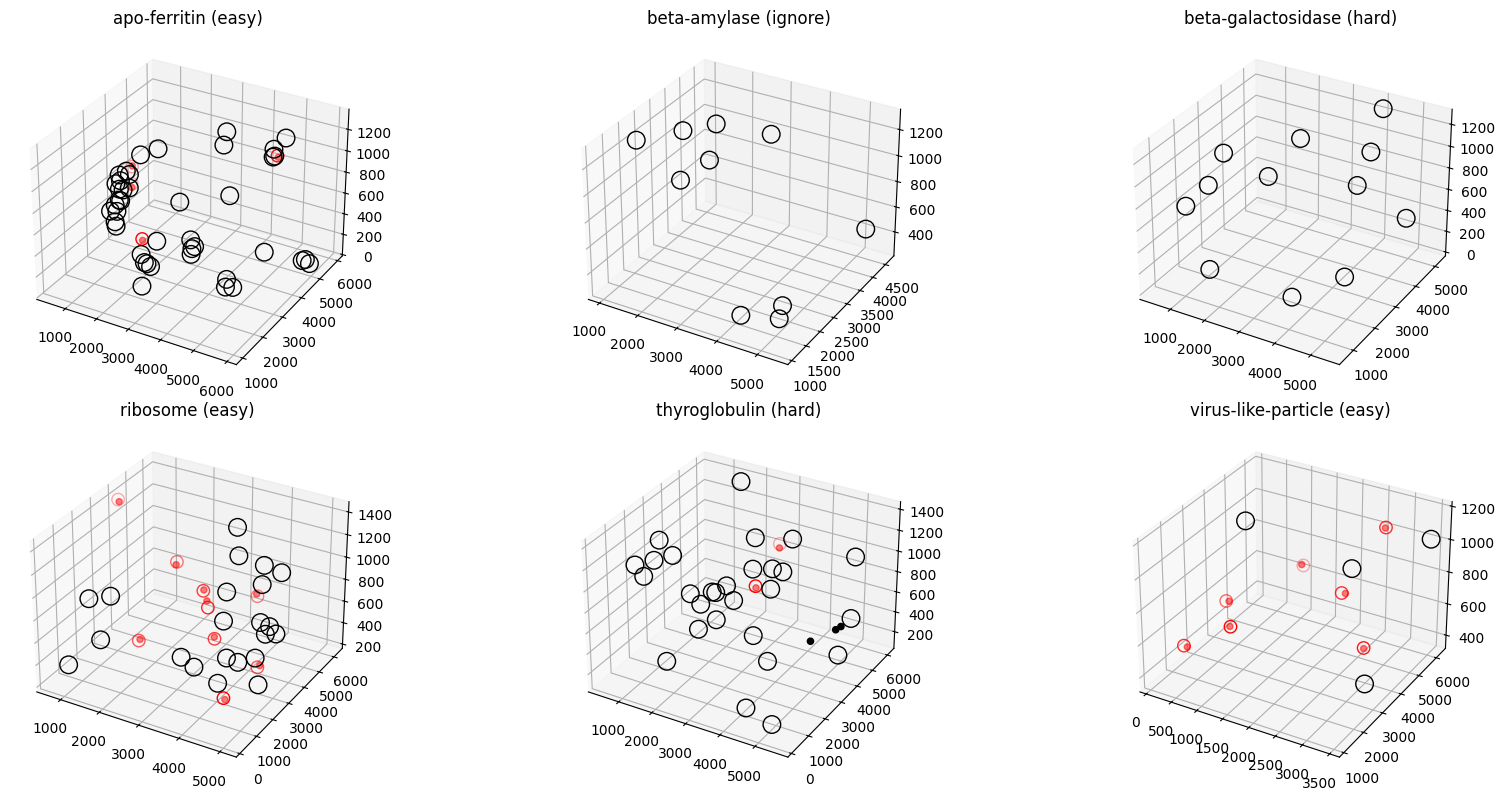

In [14]:
DATA_KAGGLE_DIR = '../input/czii-cryo-et-object-identification'
valid_dir =f'{DATA_KAGGLE_DIR}/train' 
valid_id = glob.glob(f'{valid_dir}/static/ExperimentRuns/*')
valid_id = [f.split('/')[-1] for f in valid_id]

import pandas as pd
import numpy as np
import json
import zarr
from scipy.optimize import linear_sum_assignment
class dotdict(dict):
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    def __getattr__(self, name):
        try:
            return self[name]
        except KeyError:
            raise AttributeError(name)
            
PARTICLE= [
    {
        "name": "apo-ferritin",
        "difficulty": 'easy',
        "pdb_id": "4V1W",
        "label": 1,
        "color": [0, 255, 0, 0],
        "radius": 60,
        "map_threshold": 0.0418
    },
    {
        "name": "beta-amylase",
        "difficulty": 'ignore',
        "pdb_id": "1FA2",
        "label": 2,
        "color": [0, 0, 255, 255],
        "radius": 65,
        "map_threshold": 0.035
    },
    {
        "name": "beta-galactosidase",
        "difficulty": 'hard',
        "pdb_id": "6X1Q",
        "label": 3,
        "color": [0, 255, 0, 255],
        "radius": 90,
        "map_threshold": 0.0578
    },
    {
        "name": "ribosome",
        "difficulty": 'easy',
        "pdb_id": "6EK0",
        "label": 4,
        "color": [0, 0, 255, 0],
        "radius": 150,
        "map_threshold": 0.0374
    },
    {
        "name": "thyroglobulin",
        "difficulty": 'hard',
        "pdb_id": "6SCJ",
        "label": 5,
        "color": [0, 255, 255, 0],
        "radius": 130,
        "map_threshold": 0.0278
    },
    {
        "name": "virus-like-particle",
        "difficulty": 'easy',
        "pdb_id": "6N4V",
        "label": 6,
        "color": [0, 0, 0, 255],
        "radius": 135,
        "map_threshold": 0.201
    }
]

PARTICLE_COLOR=[[0,0,0]]+[
    PARTICLE[i]['color'][1:] for i in range(6)
]
PARTICLE_NAME=['none']+[
    PARTICLE[i]['name'] for i in range(6)
]

'''
(184, 630, 630)  
(92, 315, 315)  
(46, 158, 158)  
'''

def read_one_data(id, static_dir):
    zarr_dir = f'{static_dir}/{id}/VoxelSpacing10.000'
    zarr_file = f'{zarr_dir}/denoised.zarr'
    zarr_data = zarr.open(zarr_file, mode='r')
    volume = zarr_data[0][:]
    max = volume.max()
    min = volume.min()
    volume = (volume - min) / (max - min)
    volume = volume.astype(np.float16)
    return volume


def read_one_truth(id, overlay_dir):
    location={}

    json_dir = f'{overlay_dir}/{id}/Picks'
    for p in PARTICLE_NAME[1:]:
        json_file = f'{json_dir}/{p}.json'

        with open(json_file, 'r') as f:
            json_data = json.load(f)

        num_point = len(json_data['points'])
        loc = np.array([list(json_data['points'][i]['location'].values()) for i in range(num_point)])
        location[p] = loc

    return location
    
def do_one_eval(truth, predict, threshold):
    P=len(predict)
    T=len(truth)

    if P==0:
        hit=[[],[]]
        miss=np.arange(T).tolist()
        fp=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    if T==0:
        hit=[[],[]]
        fp=np.arange(P).tolist()
        miss=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    #---
    distance = predict.reshape(P,1,3)-truth.reshape(1,T,3)
    distance = distance**2
    distance = distance.sum(axis=2)
    distance = np.sqrt(distance)
    p_index, t_index = linear_sum_assignment(distance)

    valid = distance[p_index, t_index] <= threshold
    p_index = p_index[valid]
    t_index = t_index[valid]
    hit = [p_index.tolist(), t_index.tolist()]
    miss = np.arange(T)
    miss = miss[~np.isin(miss,t_index)].tolist()
    fp = np.arange(P)
    fp = fp[~np.isin(fp,p_index)].tolist()

    metric = [P,T,len(hit[0]),len(miss),len(fp)] #for lb metric F-beta copmutation
    return hit, fp, miss, metric


def compute_lb(submit_df, overlay_dir):
    valid_id = list(submit_df['experiment'].unique())
    print(valid_id)

    eval_df = []
    for id in valid_id:
        truth = read_one_truth(id, overlay_dir) #=f'{valid_dir}/overlay/ExperimentRuns')
        id_df = submit_df[submit_df['experiment'] == id]
        for p in PARTICLE:
            p = dotdict(p)
            print('\r', id, p.name, end='', flush=True)
            xyz_truth = truth[p.name]
            xyz_predict = id_df[id_df['particle_type'] == p.name][['x', 'y', 'z']].values
            hit, fp, miss, metric = do_one_eval(xyz_truth, xyz_predict, p.radius* 0.5)
            eval_df.append(dotdict(
                id=id, particle_type=p.name,
                P=metric[0], T=metric[1], hit=metric[2], miss=metric[3], fp=metric[4],
            ))
    print('')
    eval_df = pd.DataFrame(eval_df)
    gb = eval_df.groupby('particle_type').agg('sum').drop(columns=['id'])
    gb.loc[:, 'precision'] = gb['hit'] / gb['P']
    gb.loc[:, 'precision'] = gb['precision'].fillna(0)
    gb.loc[:, 'recall'] = gb['hit'] / gb['T']
    gb.loc[:, 'recall'] = gb['recall'].fillna(0)
    gb.loc[:, 'f-beta4'] = 17 * gb['precision'] * gb['recall'] / (16 * gb['precision'] + gb['recall'])
    gb.loc[:, 'f-beta4'] = gb['f-beta4'].fillna(0)

    gb = gb.sort_values('particle_type').reset_index(drop=False)
    # https://www.kaggle.com/competitions/czii-cryo-et-object-identification/discussion/544895
    gb.loc[:, 'weight'] = [1, 0, 2, 1, 2, 1]
    lb_score = (gb['f-beta4'] * gb['weight']).sum() / gb['weight'].sum()
    return gb, lb_score


#debug
if 1:
    if 1:
    #if 1:
        submit_df=pd.read_csv(
           'submission.csv'
            # '/kaggle/input/hengck-czii-cryo-et-weights-01/submission.csv'
        )
        gb, lb_score = compute_lb(submit_df, f'{valid_dir}/overlay/ExperimentRuns')
        print(gb)
        print('lb_score:',lb_score)
        print('')


        #show one ----------------------------------
        fig = plt.figure(figsize=(18, 8))

        id = valid_id[0]
        truth = read_one_truth(id,overlay_dir=f'{valid_dir}/overlay/ExperimentRuns')

        submit_df = submit_df[submit_df['experiment']==id]
        for p in PARTICLE:
            p = dotdict(p)
            xyz_truth = truth[p.name]
            xyz_predict = submit_df[submit_df['particle_type']==p.name][['x','y','z']].values
            hit, fp, miss, _ = do_one_eval(xyz_truth, xyz_predict, p.radius)
            print(id, p.name)
            print('\t num truth   :',len(xyz_truth) )
            print('\t num predict :',len(xyz_predict) )
            print('\t num hit  :',len(hit[0]) )
            print('\t num fp   :',len(fp) )
            print('\t num miss :',len(miss) )

            ax = fig.add_subplot(2, 3, p.label, projection='3d')
            if hit[0]:
                pt = xyz_predict[hit[0]]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=0.5, color='r')
                pt = xyz_truth[hit[1]]
                ax.scatter(pt[:,0], pt[:,1], pt[:,2], s=80, facecolors='none', edgecolors='r')
            if fp:
                pt = xyz_predict[fp]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=1, color='k')
            if miss:
                pt = xyz_truth[miss]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], s=160, alpha=1, facecolors='none', edgecolors='k')

            ax.set_title(f'{p.name} ({p.difficulty})')

        plt.tight_layout()
        plt.show()
        
        #--- 
        zz=0

In [46]:
result_params = []
result_lb = []
for i in range (10):
    print(f"conf_coef={i *0.01}")
    particle_confs = np.array([i *0.01,0, i *0.01, i *0.01, i *0.01, i *0.01])
    aggregator = PredictionAggregator(first_conf=0.01,  conf_coef=0.1,particle_confs=particle_confs) #Update
    aggregated_results = []


    with ProcessPoolExecutor(max_workers=2) as executor:
        results = list(executor.map(inference, (runs1, runs2), (model, model), ("0", "1")))

    submission = pd.concat(results[1])
    submission.insert(0, 'id', range(len(submission)))
    submission.to_csv("submission.csv", index=False)
    submission.head()

    gb, lb_score = compute_lb(submission, f'{valid_dir}/overlay/ExperimentRuns')
    print(gb, lb_score)

    result_params.append([i *0.05, lb_score])


conf_coef=0.0


0it [00:00, ?it/s]/1 [00:00<?, ?it/s]
100%|██████████| 1/1 [00:15<00:00, 15.14s/it]


['TS_5_4']
 TS_5_4 virus-like-particle
         particle_type    P   T  hit  miss   fp  precision    recall  \
0         apo-ferritin  226  46   24    22  202   0.106195  0.521739   
1         beta-amylase    0  10    0    10    0   0.000000  0.000000   
2   beta-galactosidase  314  12    7     5  307   0.022293  0.583333   
3             ribosome   35  31   11    20   24   0.314286  0.354839   
4        thyroglobulin  189  30   21     9  168   0.111111  0.700000   
5  virus-like-particle    9  11    8     3    1   0.888889  0.727273   

    f-beta4  weight  
0  0.424116       1  
1  0.000000       0  
2  0.235178       2  
3  0.352166       1  
4  0.533632       2  
5  0.735135       1   0.4355767985021383
conf_coef=0.01


0it [00:00, ?it/s]/1 [00:00<?, ?it/s]
100%|██████████| 1/1 [00:15<00:00, 15.11s/it]


['TS_5_4']
 TS_5_4 virus-like-particle
         particle_type    P   T  hit  miss   fp  precision    recall  \
0         apo-ferritin  226  46   24    22  202   0.106195  0.521739   
1         beta-amylase    0  10    0    10    0   0.000000  0.000000   
2   beta-galactosidase  314  12    7     5  307   0.022293  0.583333   
3             ribosome   35  31   11    20   24   0.314286  0.354839   
4        thyroglobulin  189  30   21     9  168   0.111111  0.700000   
5  virus-like-particle    9  11    8     3    1   0.888889  0.727273   

    f-beta4  weight  
0  0.424116       1  
1  0.000000       0  
2  0.235178       2  
3  0.352166       1  
4  0.533632       2  
5  0.735135       1   0.4355767985021383
conf_coef=0.02


0it [00:00, ?it/s]/1 [00:00<?, ?it/s]
100%|██████████| 1/1 [00:13<00:00, 13.09s/it]


['TS_5_4']
 TS_5_4 virus-like-particle
         particle_type    P   T  hit  miss   fp  precision    recall  \
0         apo-ferritin  226  46   24    22  202   0.106195  0.521739   
1         beta-amylase    0  10    0    10    0   0.000000  0.000000   
2   beta-galactosidase  310  12    7     5  303   0.022581  0.583333   
3             ribosome   35  31   11    20   24   0.314286  0.354839   
4        thyroglobulin  189  30   21     9  168   0.111111  0.700000   
5  virus-like-particle    9  11    8     3    1   0.888889  0.727273   

    f-beta4  weight  
0  0.424116       1  
1  0.000000       0  
2  0.237052       2  
3  0.352166       1  
4  0.533632       2  
5  0.735135       1   0.4361122062781489
conf_coef=0.03


0it [00:00, ?it/s]/1 [00:00<?, ?it/s]
100%|██████████| 1/1 [00:13<00:00, 13.65s/it]


['TS_5_4']
 TS_5_4 virus-like-particle
         particle_type    P   T  hit  miss   fp  precision    recall  \
0         apo-ferritin  226  46   24    22  202   0.106195  0.521739   
1         beta-amylase    0  10    0    10    0   0.000000  0.000000   
2   beta-galactosidase  253  12    6     6  247   0.023715  0.500000   
3             ribosome   35  31   11    20   24   0.314286  0.354839   
4        thyroglobulin  189  30   21     9  168   0.111111  0.700000   
5  virus-like-particle    9  11    8     3    1   0.888889  0.727273   

    f-beta4  weight  
0  0.424116       1  
1  0.000000       0  
2  0.229213       2  
3  0.352166       1  
4  0.533632       2  
5  0.735135       1   0.43387268922597233
conf_coef=0.04


0it [00:00, ?it/s]/1 [00:00<?, ?it/s]
100%|██████████| 1/1 [00:14<00:00, 14.65s/it]


['TS_5_4']
 TS_5_4 virus-like-particle
         particle_type    P   T  hit  miss   fp  precision    recall  \
0         apo-ferritin  226  46   24    22  202   0.106195  0.521739   
1         beta-amylase    0  10    0    10    0   0.000000  0.000000   
2   beta-galactosidase  198  12    5     7  193   0.025253  0.416667   
3             ribosome   35  31   11    20   24   0.314286  0.354839   
4        thyroglobulin  189  30   21     9  168   0.111111  0.700000   
5  virus-like-particle    9  11    8     3    1   0.888889  0.727273   

    f-beta4  weight  
0  0.424116       1  
1  0.000000       0  
2  0.217949       2  
3  0.352166       1  
4  0.533632       2  
5  0.735135       1   0.43065418488387247
conf_coef=0.05


0it [00:00, ?it/s]/1 [00:00<?, ?it/s]
100%|██████████| 1/1 [00:15<00:00, 15.20s/it]


['TS_5_4']
 TS_5_4 virus-like-particle
         particle_type    P   T  hit  miss   fp  precision    recall  \
0         apo-ferritin  222  46   24    22  198   0.108108  0.521739   
1         beta-amylase    0  10    0    10    0   0.000000  0.000000   
2   beta-galactosidase  161  12    5     7  156   0.031056  0.416667   
3             ribosome   35  31   11    20   24   0.314286  0.354839   
4        thyroglobulin  188  30   21     9  167   0.111702  0.700000   
5  virus-like-particle    9  11    8     3    1   0.888889  0.727273   

    f-beta4  weight  
0  0.425887       1  
1  0.000000       0  
2  0.240793       2  
3  0.352166       1  
4  0.534431       2  
5  0.735135       1   0.43766240043332943
conf_coef=0.06


0it [00:00, ?it/s]/1 [00:00<?, ?it/s]
100%|██████████| 1/1 [00:14<00:00, 14.96s/it]


['TS_5_4']
 TS_5_4 virus-like-particle
         particle_type    P   T  hit  miss   fp  precision    recall  \
0         apo-ferritin  216  46   24    22  192   0.111111  0.521739   
1         beta-amylase    0  10    0    10    0   0.000000  0.000000   
2   beta-galactosidase  132  12    5     7  127   0.037879  0.416667   
3             ribosome   35  31   11    20   24   0.314286  0.354839   
4        thyroglobulin  184  30   21     9  163   0.114130  0.700000   
5  virus-like-particle    9  11    8     3    1   0.888889  0.727273   

    f-beta4  weight  
0  0.428571       1  
1  0.000000       0  
2  0.262346       2  
3  0.352166       1  
4  0.537651       2  
5  0.735135       1   0.4451235502282304
conf_coef=0.07


0it [00:00, ?it/s]/1 [00:00<?, ?it/s]
100%|██████████| 1/1 [00:14<00:00, 14.91s/it]


['TS_5_4']
 TS_5_4 virus-like-particle
         particle_type    P   T  hit  miss   fp  precision    recall  \
0         apo-ferritin  204  46   24    22  180   0.117647  0.521739   
1         beta-amylase    0  10    0    10    0   0.000000  0.000000   
2   beta-galactosidase  109  12    5     7  104   0.045872  0.416667   
3             ribosome   35  31   11    20   24   0.314286  0.354839   
4        thyroglobulin  175  30   21     9  154   0.120000  0.700000   
5  virus-like-particle    9  11    8     3    1   0.888889  0.727273   

    f-beta4  weight  
0  0.434043       1  
1  0.000000       0  
2  0.282392       2  
3  0.352166       1  
4  0.545038       2  
5  0.735135       1   0.45374340034395916
conf_coef=0.08


0it [00:00, ?it/s]/1 [00:00<?, ?it/s]
100%|██████████| 1/1 [00:15<00:00, 15.20s/it]


['TS_5_4']
 TS_5_4 virus-like-particle
         particle_type    P   T  hit  miss   fp  precision    recall  \
0         apo-ferritin  199  46   24    22  175   0.120603  0.521739   
1         beta-amylase    0  10    0    10    0   0.000000  0.000000   
2   beta-galactosidase   92  12    4     8   88   0.043478  0.333333   
3             ribosome   35  31   11    20   24   0.314286  0.354839   
4        thyroglobulin  168  30   21     9  147   0.125000  0.700000   
5  virus-like-particle    9  11    8     3    1   0.888889  0.727273   

    f-beta4  weight  
0  0.436364       1  
1  0.000000       0  
2  0.239437       2  
3  0.352166       1  
4  0.550926       2  
5  0.735135       1   0.4434842268334748
conf_coef=0.09


0it [00:00, ?it/s]/1 [00:00<?, ?it/s]
100%|██████████| 1/1 [00:12<00:00, 12.99s/it]


['TS_5_4']
 TS_5_4 virus-like-particle
         particle_type    P   T  hit  miss   fp  precision    recall  \
0         apo-ferritin  194  46   24    22  170   0.123711  0.521739   
1         beta-amylase    0  10    0    10    0   0.000000  0.000000   
2   beta-galactosidase   77  12    3     9   74   0.038961  0.250000   
3             ribosome   35  31   11    20   24   0.314286  0.354839   
4        thyroglobulin  161  30   21     9  140   0.130435  0.700000   
5  virus-like-particle    9  11    8     3    1   0.888889  0.727273   

    f-beta4  weight  
0  0.438710       1  
1  0.000000       0  
2  0.189591       2  
3  0.352166       1  
4  0.556942       2  
5  0.735135       1   0.431296749873945


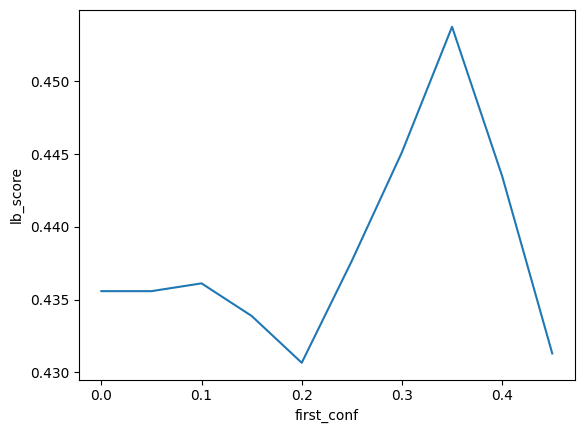

In [47]:
#グラフで表示
result_params = np.array(result_params)
plt.plot(result_params[:,0], result_params[:,1])
plt.xlabel('first_conf')
plt.ylabel('lb_score')
plt.show()